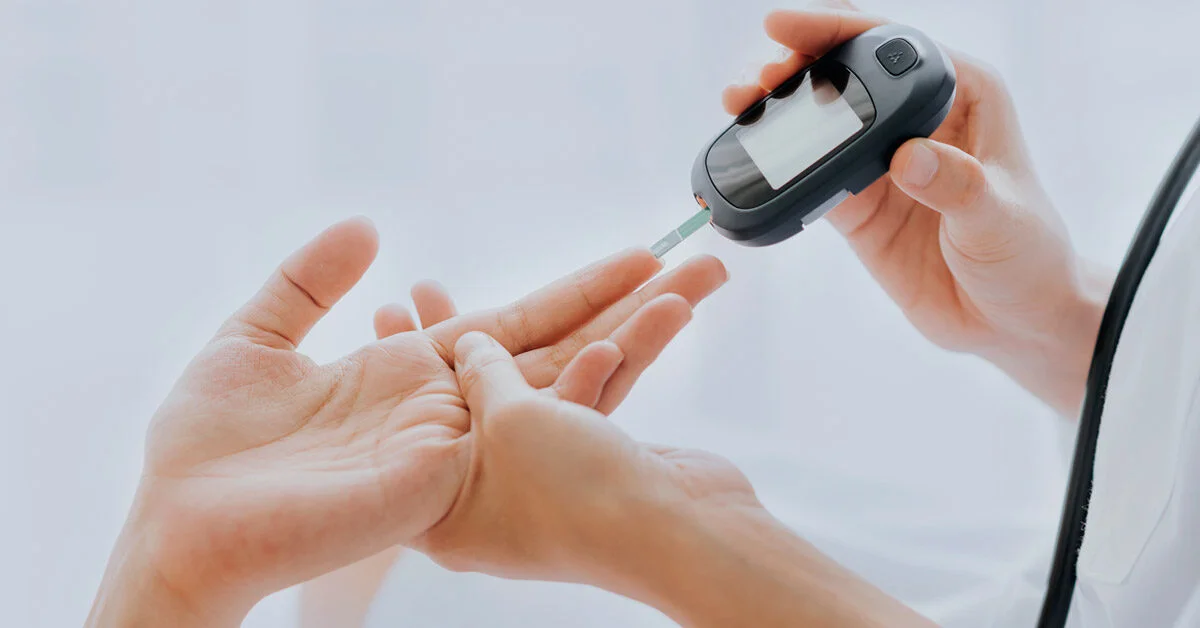

# The Dataset Story

The dataset is a part of a large dataset maintained by the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. It is used for a diabetes research study conducted on Pima Indian women aged 21 and above, residing in Phoenix, the 5th largest city in the state of Arizona.

The target variable is denoted as "outcome," where 1 indicates a positive diabetes test result, and 0 indicates a negative result.

In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import warnings


from catboost import CatBoostClassifier
import logging
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
warnings.simplefilter("ignore")

In [158]:
df=pd.read_csv("/kaggle/input/docspot/datasets_228_482_diabetes.csv")

# Task 1: Exploratory Data Analysis

In [159]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## Step 1: Examine the overall data.

In [160]:
df.shape


(768, 9)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [162]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

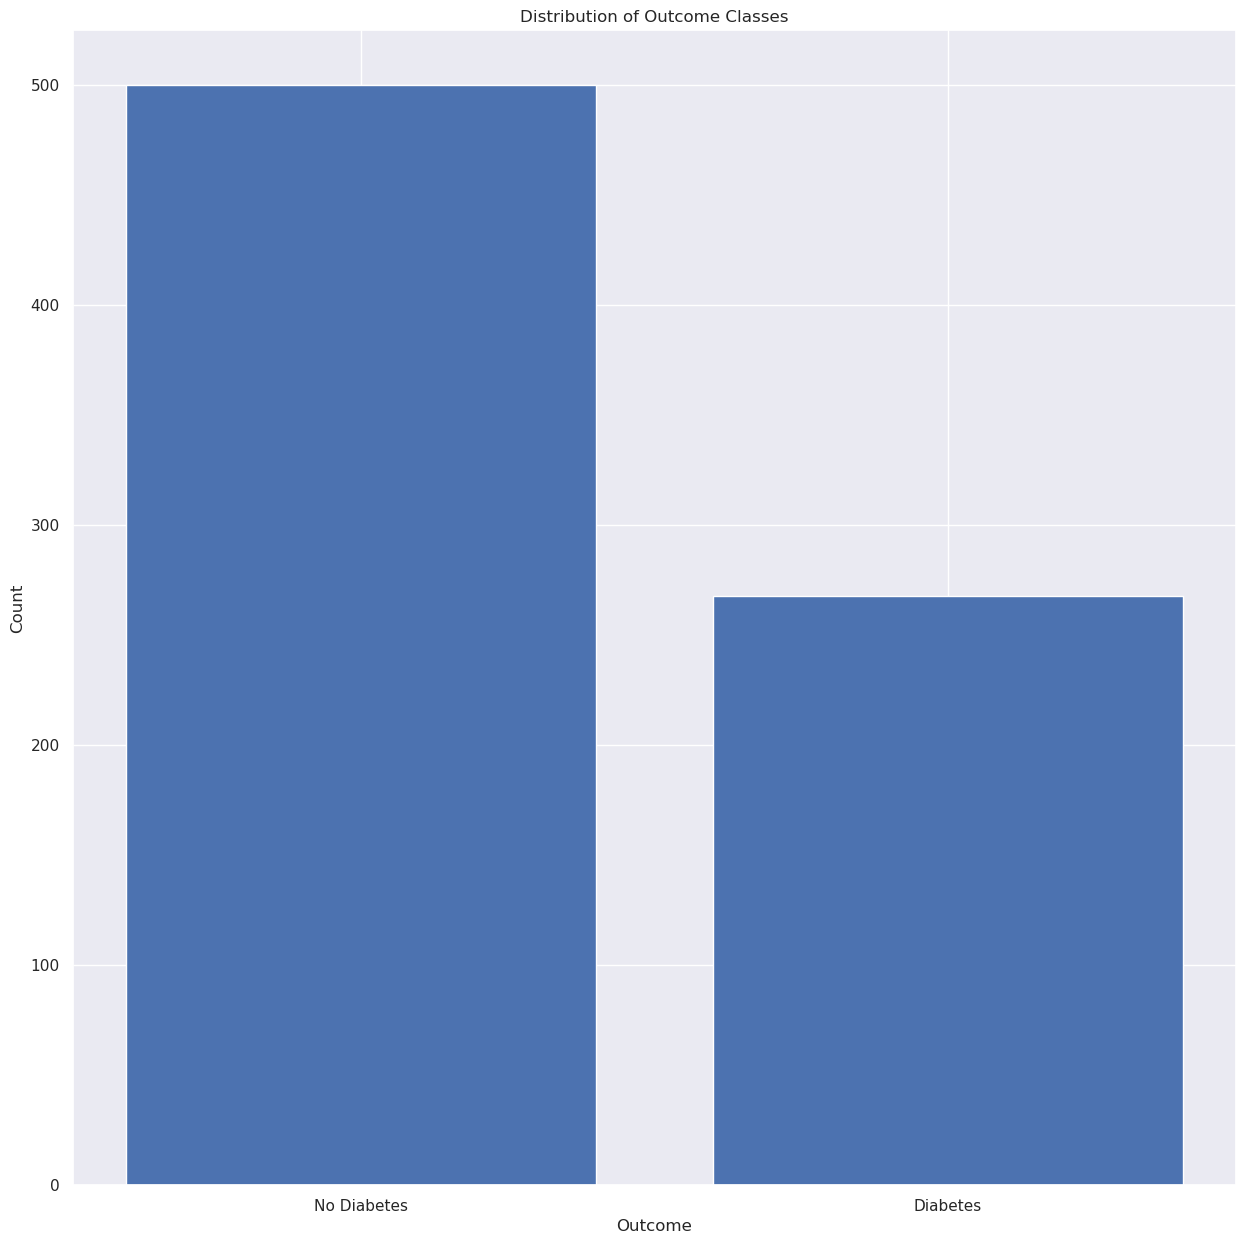

In [163]:
outcome_counts = df['Outcome'].value_counts()
plt.bar(outcome_counts.index, outcome_counts.values)
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Outcome Classes')
plt.show()

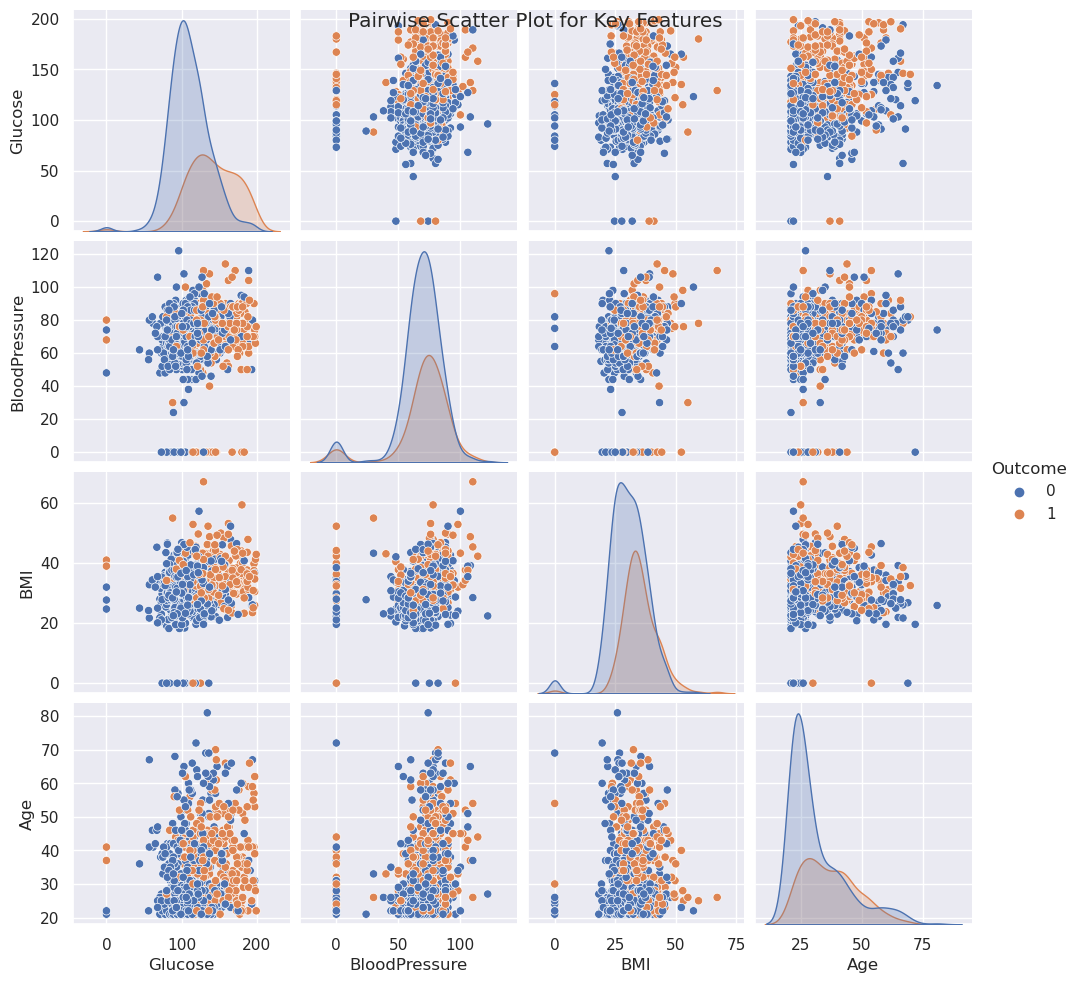

In [164]:
key_features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
sns.pairplot(df, vars=key_features, hue='Outcome', diag_kind='kde')
plt.suptitle('Pairwise Scatter Plot for Key Features')
plt.show()

## Step 2: Capture numeric and categorical variables

In [165]:
def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car




In [166]:

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [167]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

## Step 3: Analyze the numerical and categorical variables.

In [168]:
def cat_summary(dataframe, col_name):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

In [169]:
for col in cat_cols:
    cat_summary(df, col)


   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


In [170]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)




In [171]:
for col in num_cols:
    num_summary(df, col)


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10% 

## Step 4: Perform target variable analysis. 
(The mean of the target variable according to the categorical variables,
mean of numerical variables)

In [172]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [173]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [174]:
df.groupby("Outcome")["Glucose"].agg(["mean", "std", "min", "max"])

,mean,std,min,max
Outcome,,,,
0,109.980,26.141,0,197
1,141.257,31.940,0,199


In [175]:
df.groupby('Outcome').agg({'Glucose': ['mean', 'median', 'std'],
                                             'BMI': ['mean', 'median', 'std'],
                                             'Age': ['mean', 'median', 'std']})

Glucose                   BMI                 Age              
           mean  median    std   mean median   std   mean median    std
Outcome                                                                
0       109.980 107.000 26.141 30.304 30.050 7.690 31.190 27.000 11.668
1       141.257 140.000 31.940 35.143 34.250 7.263 37.067 36.000 10.968

In [176]:
df.groupby('Outcome').agg('mean')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298,109.980,68.184,19.664,68.792,30.304,0.430,31.190
1,4.866,141.257,70.825,22.164,100.336,35.143,0.550,37.067


## Step 5: Perform outlier analysis.

In [177]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    up_limit, low_limit = outlier_thresholds(dataframe, col_name)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].shape[0] > 10:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].head())
    else:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)])

    if index:
        outliers_index = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].index
        return outliers_index

    

In [178]:
for col in num_cols:
    print(col,check_outlier(df,col))


Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


## Step 6: Perform missing observation analysis.

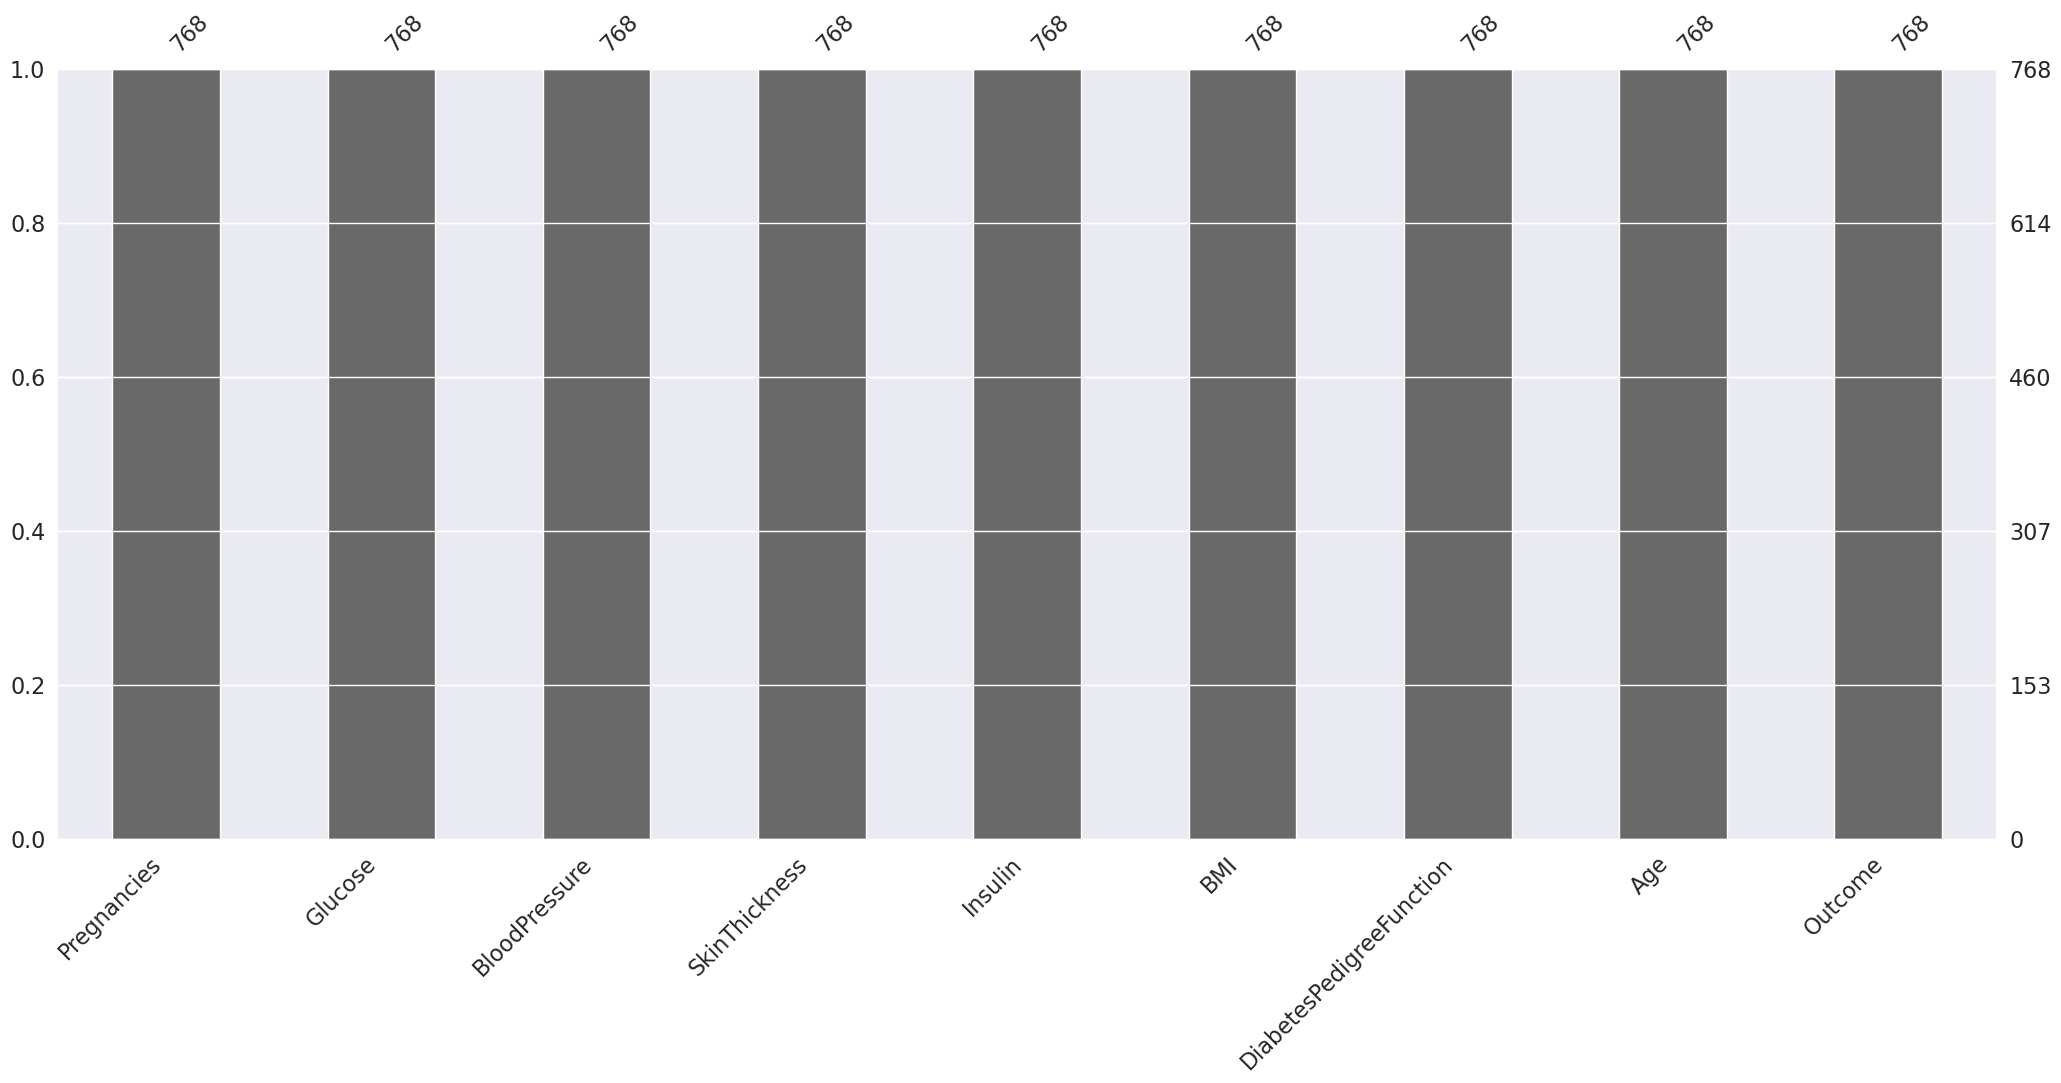

In [179]:
msno.bar(df)
plt.show()



In [180]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if na_name:
        return na_cols

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


##  Step 7: Perform correlation analysis.

In [181]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

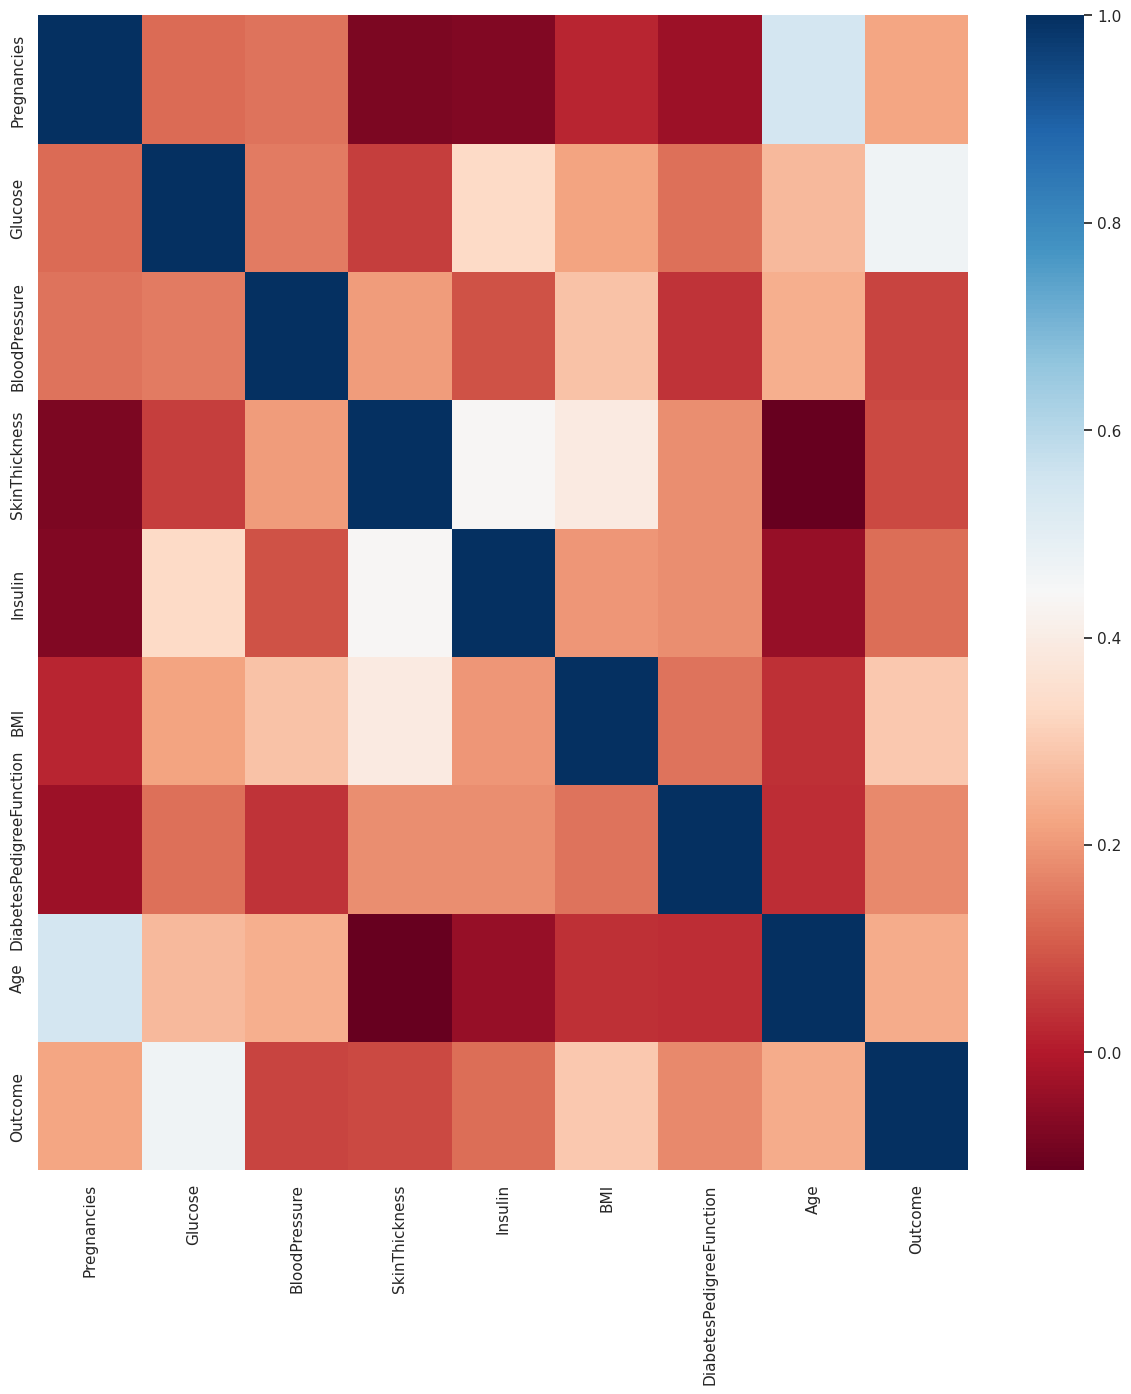

In [182]:
high_correlated_cols(df)
drop_list = high_correlated_cols(df, plot=True)


# Task 2 : Feature Engineering

## Step 1: Take necessary actions for missing and outlier values.

There are no missing observations in the dataset, but certain variables, such as Glucose and Insulin, may contain zero values, which could indicate missing values. For example, a person's glucose or insulin level cannot be zero. To address this, we will replace the zero values with NaN (Not a Number) to represent missing values and subsequently apply appropriate techniques for handling missing values.

In [183]:
zero_as_nan_cols = [col for col in df.columns if df[col].min() == 0
                and col not in ["Outcome", "Pregnancies"]]

In [184]:
zero_as_nan_cols

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [185]:
df[zero_as_nan_cols] = df[zero_as_nan_cols].replace(0, np.nan)


In [186]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)


               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [187]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)


                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [188]:
for col in zero_as_nan_cols:
    df.loc[df[col].isnull(), col] = df[col].median()


In [189]:
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [190]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [191]:

for col in num_cols:
    print(col,check_outlier(df,col))


Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [192]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



In [193]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [194]:

for col in num_cols:
    print(col,check_outlier(df,col))


Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


## Step 2: Create new features.

In [195]:
age_bins = [0, 35, 60, float('inf')]
age_labels = ['Young', 'Middle Age', 'Old']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

In [196]:
df['BMI_LABELS'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])

In [197]:
glucose_bins = [0, 70, 100, 125, float('inf')]
glucose_labels = ['Low', 'Normal', 'Pre-Diabetes', 'Diabetes']
df['GlucoseLevel'] = pd.cut(df['Glucose'], bins=glucose_bins, labels=glucose_labels, right=False)

In [198]:
insulin_bins = [-1, 0, 30, 100, 200, float('inf')]
insulin_labels = ['No Insulin', 'Low', 'Moderate', 'High', 'Very High']
df['InsulinLevel'] = pd.cut(df['Insulin'], bins=insulin_bins, labels=insulin_labels, right=False)

In [199]:
#BMI_AGE
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 35)), "NEW_BMI_AGE"] = "underweight_young"
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 35) & (df["Age"] < 60)), "NEW_BMI_AGE"] = "underweight_middleage"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 60), "NEW_BMI_AGE"] = "underweight_old"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 35)), "NEW_BMI_AGE"] = "healthy_young"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 35) & (df["Age"] < 60)), "NEW_BMI_AGE"] = "healthy_middleage"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 60), "NEW_BMI_AGE"] = "healthy_old"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 35)), "NEW_BMI_AGE"] = "overweight_young"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 35) & (df["Age"] < 60)), "NEW_BMI_AGE"] = "overweight_middleage"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 60), "NEW_BMI_AGE"] = "overweight_old"
df.loc[(df["BMI"] > 30) & ((df["Age"] >= 21) & (df["Age"] < 35)), "NEW_BMI_AGE"] = "obese_young"
df.loc[(df["BMI"] > 30) & ((df["Age"] >= 35) & (df["Age"] < 60)), "NEW_BMI_AGE"] = "obese_middleage"
df.loc[(df["BMI"] > 30) & (df["Age"] >= 60), "NEW_BMI_AGE"] = "obese_old"

In [200]:
#GLUCOSE_AGE
df.loc[(df["Glucose"] < 70) & (df["AgeGroup"]=="Young"), "NEW_GLUCOSE_AGE"] = "low_young"
df.loc[(df["Glucose"] < 70) & (df["AgeGroup"]=="Middle Age"), "NEW_GLUCOSE_AGE"] = "low_middleage"
df.loc[(df["Glucose"] < 70) & (df["AgeGroup"]=="Old"), "NEW_GLUCOSE_AGE"] = "low_old"

df.loc[(df["Glucose"] >= 70) & (df["Glucose"] < 100) & (df["AgeGroup"] == "Young"), "NEW_GLUCOSE_AGE"] = "normal_young"
df.loc[(df["Glucose"] >= 70) & (df["Glucose"] < 100) & (df["AgeGroup"] == "Middle Age"), "NEW_GLUCOSE_AGE"] = "normal_middleage"
df.loc[(df["Glucose"] >= 70) & (df["Glucose"] < 100) & (df["AgeGroup"] == "Old"), "NEW_GLUCOSE_AGE"] = "normal_old"

df.loc[(df["Glucose"] >= 100) & (df["Glucose"] < 125) & (df["AgeGroup"] == "Young"), "NEW_GLUCOSE_AGE"] = "prediabet_young"
df.loc[(df["Glucose"] >= 100) & (df["Glucose"] < 125) & (df["AgeGroup"] == "Middle Age"), "NEW_GLUCOSE_AGE"] = "prediabet_middleage"
df.loc[(df["Glucose"] >= 100) & (df["Glucose"] < 125) & (df["AgeGroup"] == "Old"), "NEW_GLUCOSE_AGE"] = "prediabet_old"

df.loc[(df["Glucose"] > 125) & (df["AgeGroup"]=="Young"), "NEW_GLUCOSE_AGE"] = "diabet_young"
df.loc[(df["Glucose"] > 125) & (df["AgeGroup"]=="Middle Age"), "NEW_GLUCOSE_AGE"] = "diabet_middleage"
df.loc[(df["Glucose"] > 125) & (df["AgeGroup"]=="Old"), "NEW_GLUCOSE_AGE"] = "diabet_old"



In [201]:
df['InsulinGlucoseRatio'] = df['Insulin'] / df['Glucose']
df["NEW_GLUCOSE_INSULIN"]=df["Insulin"]*df["Glucose"]
df["NEW_PREGNANCIES_GLUCOSE"] = df["Glucose"] * df["Pregnancies"]
df["WaistCircumference"] = df["Age"] * df["BMI"]
df['Diabetes_Risk_Score'] = 0.2 * df['Age'] + 0.4 * df['BMI'] + 0.3 * df['Glucose'] + 0.1 * df['Insulin']
df['Glucose_Age_Interaction'] = df['Glucose'] * df['Age']
df['Age_Insulin_Interaction'] = df['Age'] * df['Insulin']

In [202]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 22
cat_cols: 7
num_cols: 15
cat_but_car: 0
num_but_cat: 1


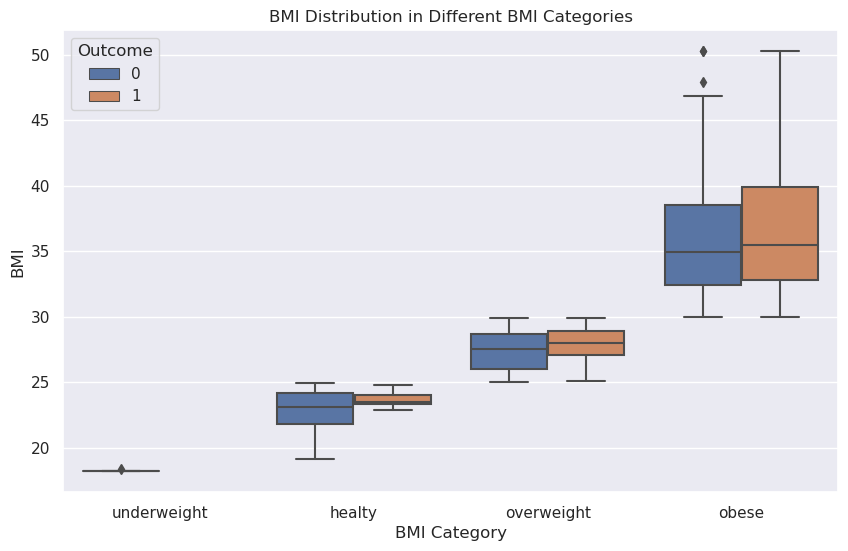

In [203]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI_LABELS', y='BMI', hue='Outcome', data=df)
plt.xlabel('BMI Category')
plt.ylabel('BMI')
plt.title('BMI Distribution in Different BMI Categories')
plt.show()

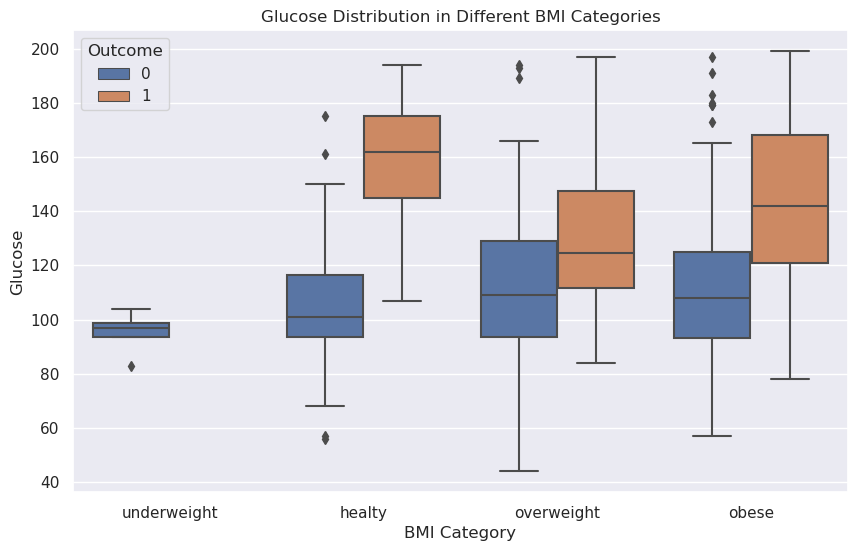

In [204]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI_LABELS', y='Glucose', hue='Outcome', data=df)
plt.xlabel('BMI Category')
plt.ylabel('Glucose')
plt.title('Glucose Distribution in Different BMI Categories')
plt.show()


## Step 3 : Perform encoding operations

In [205]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [206]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [207]:
binary_cols

[]

In [208]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
cat_cols


['AgeGroup',
 'BMI_LABELS',
 'GlucoseLevel',
 'InsulinLevel',
 'NEW_BMI_AGE',
 'NEW_GLUCOSE_AGE']

In [209]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)



In [210]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,InsulinGlucoseRatio,NEW_GLUCOSE_INSULIN,NEW_PREGNANCIES_GLUCOSE,WaistCircumference,Diabetes_Risk_Score,Glucose_Age_Interaction,Age_Insulin_Interaction,AgeGroup_Middle Age,AgeGroup_Old,BMI_LABELS_healty,BMI_LABELS_overweight,BMI_LABELS_obese,GlucoseLevel_Normal,GlucoseLevel_Pre-Diabetes,GlucoseLevel_Diabetes,InsulinLevel_Low,InsulinLevel_Moderate,InsulinLevel_High,InsulinLevel_Very High,NEW_BMI_AGE_healthy_old,NEW_BMI_AGE_healthy_young,NEW_BMI_AGE_obese_middleage,NEW_BMI_AGE_obese_old,NEW_BMI_AGE_obese_young,NEW_BMI_AGE_overweight_middleage,NEW_BMI_AGE_overweight_old,NEW_BMI_AGE_overweight_young,NEW_BMI_AGE_underweight_young,NEW_GLUCOSE_AGE_diabet_old,NEW_GLUCOSE_AGE_diabet_young,NEW_GLUCOSE_AGE_low_middleage,NEW_GLUCOSE_AGE_low_old,NEW_GLUCOSE_AGE_low_young,NEW_GLUCOSE_AGE_normal_middleage,NEW_GLUCOSE_AGE_normal_old,NEW_GLUCOSE_AGE_normal_young,NEW_GLUCOSE_AGE_prediabet_middleage,NEW_GLUCOSE_AGE_prediabet_old,NEW_GLUCOSE_AGE_prediabet_young
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,0.845,18500.000,888.000,1680.000,80.340,7400.000,6250.000,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,1.471,10625.000,85.000,824.600,54.840,2635.000,3875.000,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0.683,22875.000,1464.000,745.600,83.120,5856.000,4000.000,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,1.268,10045.875,89.000,590.100,53.428,1869.000,2370.375,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0.992,18614.875,0.000,1422.300,78.528,4521.000,4483.875,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [211]:
df.shape

(768, 48)

## Step 4 : Standardize for numeric variables.

In [212]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [213]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,InsulinGlucoseRatio,NEW_GLUCOSE_INSULIN,NEW_PREGNANCIES_GLUCOSE,WaistCircumference,Diabetes_Risk_Score,Glucose_Age_Interaction,Age_Insulin_Interaction,AgeGroup_Middle Age,AgeGroup_Old,BMI_LABELS_healty,BMI_LABELS_overweight,BMI_LABELS_obese,GlucoseLevel_Normal,GlucoseLevel_Pre-Diabetes,GlucoseLevel_Diabetes,InsulinLevel_Low,InsulinLevel_Moderate,InsulinLevel_High,InsulinLevel_Very High,NEW_BMI_AGE_healthy_old,NEW_BMI_AGE_healthy_young,NEW_BMI_AGE_obese_middleage,NEW_BMI_AGE_obese_old,NEW_BMI_AGE_obese_young,NEW_BMI_AGE_overweight_middleage,NEW_BMI_AGE_overweight_old,NEW_BMI_AGE_overweight_young,NEW_BMI_AGE_underweight_young,NEW_GLUCOSE_AGE_diabet_old,NEW_GLUCOSE_AGE_diabet_young,NEW_GLUCOSE_AGE_low_middleage,NEW_GLUCOSE_AGE_low_old,NEW_GLUCOSE_AGE_low_young,NEW_GLUCOSE_AGE_normal_middleage,NEW_GLUCOSE_AGE_normal_old,NEW_GLUCOSE_AGE_normal_young,NEW_GLUCOSE_AGE_prediabet_middleage,NEW_GLUCOSE_AGE_prediabet_old,NEW_GLUCOSE_AGE_prediabet_young
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,-0.931,0.750,0.893,1.386,1.045,1.581,1.375,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,1.509,-1.078,-0.864,-0.584,-1.218,-0.726,-0.184,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,-1.561,1.766,2.154,-0.766,1.292,0.834,-0.102,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0.720,-1.212,-0.855,-1.125,-1.343,-1.097,-1.172,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,-0.358,0.777,-1.050,0.793,0.884,0.187,0.216,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [214]:
y = df["Outcome"]
X = df.drop("Outcome", axis = 1)


In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [216]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [217]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.75
Recall: 0.648
Precision: 0.64
F1: 0.64
Auc: 0.72


In [218]:
def plot_importance(model, features, num = len(X), save = False):
  feature_imp = pd.DataFrame({"Value":model.feature_importances_, "Feature": features.columns})
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1)
  sns.barplot(x = "Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

  plt.title("Features")
  plt.tight_layout()
  plt.show()
  if save:
    plt.savefig("importances.png")



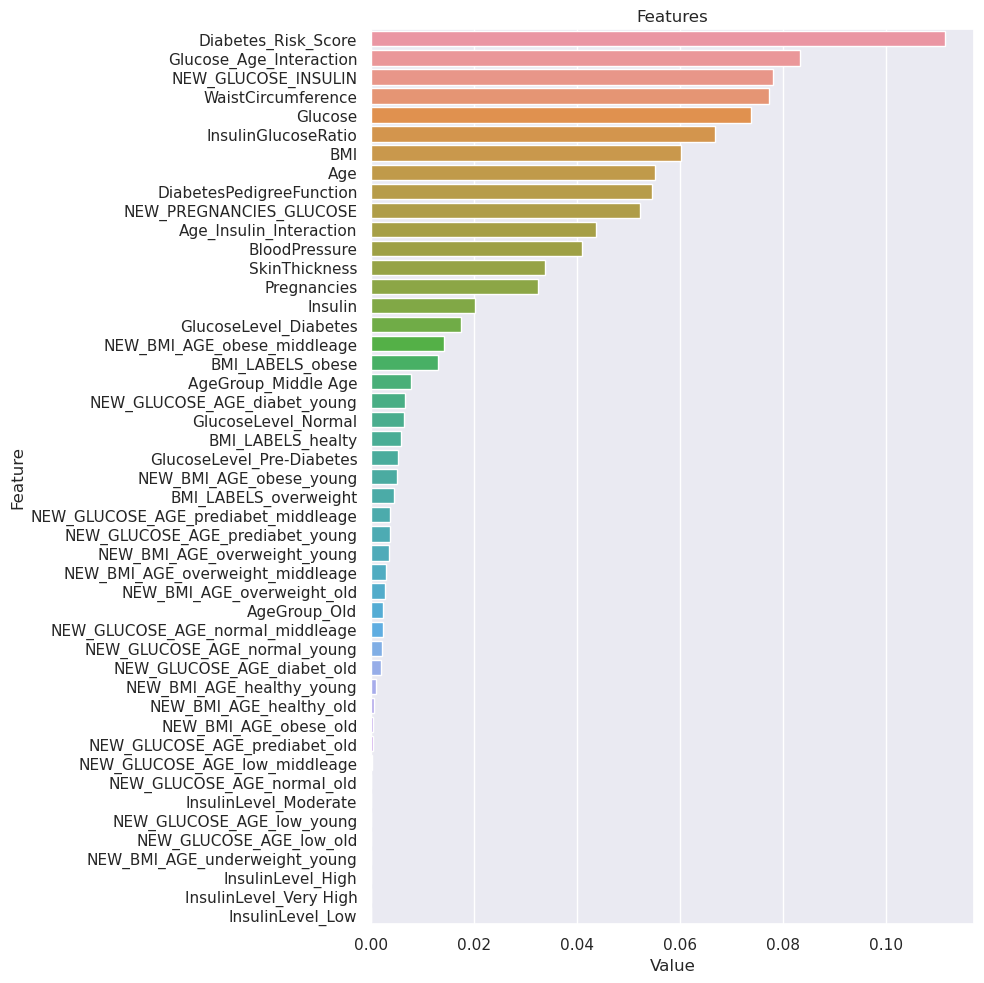

In [219]:

plot_importance(rf_model, X_train)
